# 1.0 Import of evaluation metrics

In [14]:
from pathlib import Path
from joblib import load
import pandas as pd
import re
from IPython.display import display
import pandas as pd
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [16]:
# relative to your notebooks/ cwd
folder = Path("../data/evaluation")

loaded = {}
for p in sorted(folder.glob("*.joblib")):
    try:
        obj = joblib.load(p)
    except Exception as e:
        print(f"Skipping {p.name}: load failed ({e})")
        continue

    # Ensure DataFrame
    if isinstance(obj, pd.DataFrame):
        df = obj
    else:
        try:
            df = pd.DataFrame(obj)
        except Exception:
            print(f"Skipping {p.name}: not a DataFrame and not convertible (type {type(obj).__name__})")
            continue

    # Variable name: force 'df_accuracy' for any accuracy file, else sanitized stem
    stem_lower = p.stem.lower()
    if "accuracy" in stem_lower:
        var = "df_accuracy"
    else:
        var = re.sub(r"\W|^(?=\d)", "_", p.stem)

    globals()[var] = df
    loaded[var] = df

# Show the dp_metrics_* tables (df_accuracy is now available for later use)
for name, obj in sorted(globals().items()):
    if isinstance(obj, pd.DataFrame) and name.startswith("dp_metrics_"):
        print(f"{name} (shape={obj.shape})")
        display(obj.head())

dp_metrics_baseline (shape=(43, 3))


,precision,recall,f1_score
decision_point,,,
DP 1,48.592352,48.110105,48.351095
DP 10,49.421102,49.402160,49.411631
DP 11,65.846912,65.751381,65.796057
DP 12,65.846912,65.751381,65.796057
DP 13,68.798730,68.724160,68.758425


dp_metrics_lstm_simple (shape=(43, 3))


,precision,recall,f1_score
decision_point,,,
DP 1,99.968232,99.968800,99.969200
DP 10,85.980480,87.838889,86.102789
DP 11,85.714114,86.559087,84.763817
DP 12,85.788171,86.714477,85.132486
DP 13,96.179715,96.210081,96.194949


# 1.1 Aggregation across Decision Points (Baseline, Activity, Simple, Advanced)

In [17]:
# Collect models from loaded dfs
model_stats = {}
for name, df in sorted(globals().items()):
    if isinstance(df, pd.DataFrame) and name.startswith("dp_metrics_"):
        key = "LSTM" if "lstm" in name.lower() else ("Baseline" if "baseline" in name.lower() else name)
        model_stats[key] = {
            "precision": (df["precision"].mean(), df["precision"].std()),
            "recall":    (df["recall"].mean(),    df["recall"].std()),
            "f1_score":  (df["f1_score"].mean(),  df["f1_score"].std()),
        }

print("\n=== Aggregated Across Decision Points ===")

# Precision
if "LSTM" in model_stats:
    m, s = model_stats["LSTM"]["precision"]
    print(f"Precision (LSTM):     {m:.3f} ± {s:.3f}")
if "Baseline" in model_stats:
    m, s = model_stats["Baseline"]["precision"]
    print(f"Precision (Baseline): {m:.3f} ± {s:.3f}\n")

# Recall
if "LSTM" in model_stats:
    m, s = model_stats["LSTM"]["recall"]
    print(f"Recall (LSTM):        {m:.3f} ± {s:.3f}")
if "Baseline" in model_stats:
    m, s = model_stats["Baseline"]["recall"]
    print(f"Recall (Baseline):    {m:.3f} ± {s:.3f}\n")

# F1-score
if "LSTM" in model_stats:
    m, s = model_stats["LSTM"]["f1_score"]
    print(f"F1-score (LSTM):      {m:.3f} ± {s:.3f}")
if "Baseline" in model_stats:
    m, s = model_stats["Baseline"]["f1_score"]
    print(f"F1-score (Baseline):  {m:.3f} ± {s:.3f}")



=== Aggregated Across Decision Points ===
Precision (LSTM):     89.070 ± 6.047
Precision (Baseline): 49.678 ± 18.679

Recall (LSTM):        90.505 ± 5.353
Recall (Baseline):    49.533 ± 18.577

F1-score (LSTM):      88.948 ± 6.259
F1-score (Baseline):  49.603 ± 18.628


# 1.2. F1-Score per Decision Point

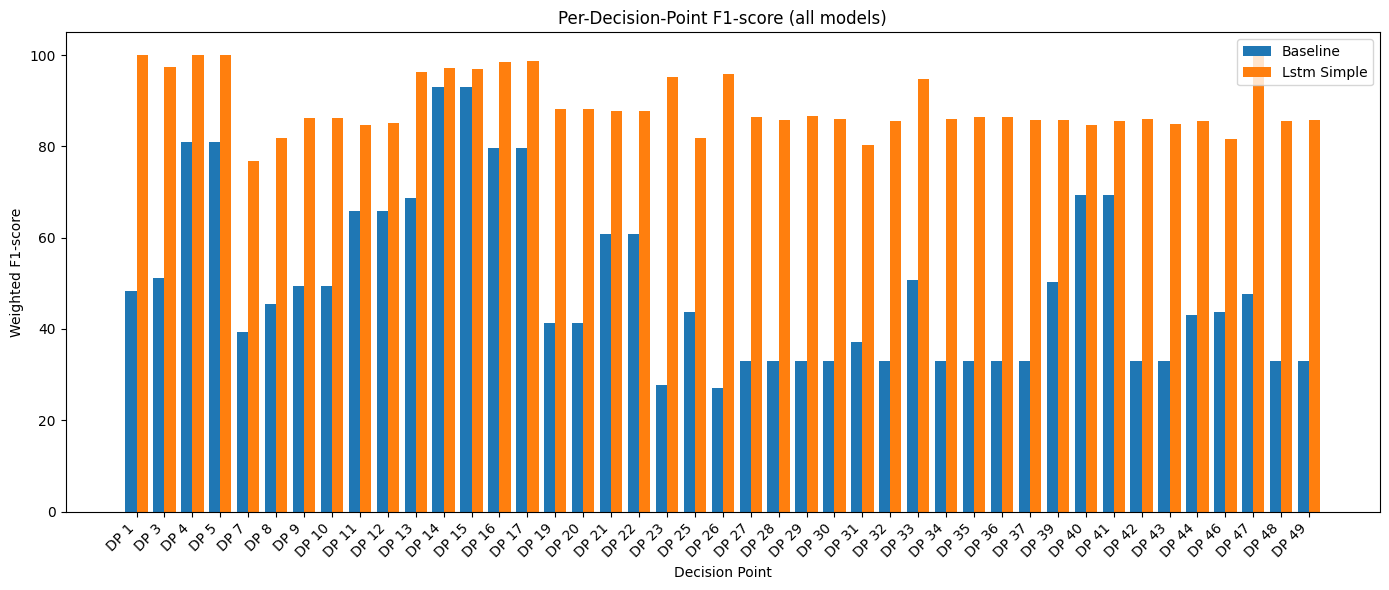

In [18]:
# Collect all loaded dp_metrics_* DataFrames and build a combined table of F1
models = {}
for name, df in sorted(globals().items()):
    if isinstance(df, pd.DataFrame) and name.startswith("dp_metrics_"):
        label = name.replace("dp_metrics_", "").replace("_", " ").title()  # e.g., "baseline" → "Baseline"
        models[label] = df

combined = None
for label, df in models.items():
    s = df["f1_score"].rename(label)
    combined = s.to_frame() if combined is None else combined.join(s, how="outer")

# Sort by DP number extracted from the index (e.g., "DP 12")
extract_num = lambda x: int(re.search(r"\d+", str(x)).group()) if re.search(r"\d+", str(x)) else float("inf")
combined["dp_number"] = combined.index.map(extract_num)
combined = combined.sort_values("dp_number").drop(columns=["dp_number"])

# Plot grouped bars with a different color per DataFrame
x = np.arange(len(combined))
n = combined.shape[1]
width = 0.8 / max(n, 1)

fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])

for i, col in enumerate(combined.columns):
    ax.bar(x - 0.4 + i*width + width/2, combined[col].values, width, label=col, color=colors[i % len(colors)])

ax.set_xlabel("Decision Point")
ax.set_ylabel("Weighted F1-score")
ax.set_title("Per-Decision-Point F1-score (all models)")
ax.set_xticks(x)
ax.set_xticklabels(combined.index, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()


# 1.3. Performance vs. Number of Classes

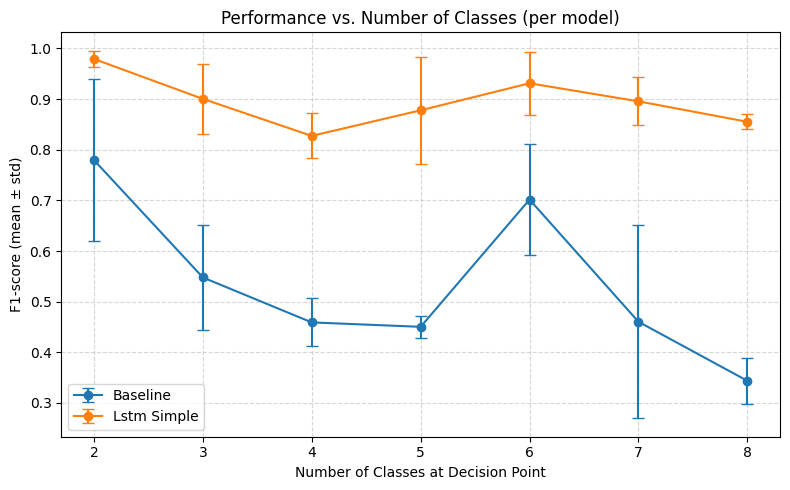

In [19]:
# 1) Num classes per DP from df_accuracy
num_classes_per_dp = (
    df_accuracy.groupby("decision_point")["label"]
    .nunique()
    .reset_index()
    .rename(columns={"label": "num_classes"})
)

# 2) Collect all loaded dp_metrics_* DataFrames
models = {}
for name, df in sorted(globals().items()):
    if isinstance(df, pd.DataFrame) and name.startswith("dp_metrics_"):
        label = name.replace("dp_metrics_", "").replace("_", " ").title()  # e.g., "baseline" -> "Baseline"
        models[label] = df

# 3) Build per-model grouped stats of F1 vs num_classes
grouped_by_model = {}
for label, df in models.items():
    perf = df.reset_index().merge(num_classes_per_dp, on="decision_point", how="inner")
    # convert percentages to fractions if needed
    for col in ["precision", "recall", "f1_score"]:
        if perf[col].max() > 1:
            perf[col] = perf[col] / 100.0
    grouped = perf.groupby("num_classes")[["f1_score"]].agg(["mean", "std"])
    grouped_by_model[label] = grouped

# 4) Union of x-values (num_classes) across all models
x_vals = sorted(set().union(*[g.index for g in grouped_by_model.values()]))

# 5) Plot error bars for each model (different color per model automatically)
plt.figure(figsize=(8, 5))
for label, grouped in grouped_by_model.items():
    gi = grouped.reindex(x_vals)
    y = gi["f1_score"]["mean"].values
    yerr = gi["f1_score"]["std"].values
    plt.errorbar(x_vals, y, yerr=yerr, fmt='o-', capsize=4, label=label)

plt.xlabel("Number of Classes at Decision Point")
plt.ylabel("F1-score (mean ± std)")
plt.title("Performance vs. Number of Classes (per model)")
plt.xticks(x_vals)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()